# Dataset for training models
A [NNDataset][] is a collection of [MPPDatas][MPPData] (one for train/val/test). It is created using a parameter file defining its properties.

This notebooks shows:

- how to create a dataset from parameters
- how to iterate over an existing dataset

[NNDataset]: ../classes/campa.data.NNDataset.rst
[MPPData]: ../classes/campa.data.MPPData.rst

In [1]:
from pathlib import Path
import os

from campa.data import NNDataset, create_dataset, load_example_data
from campa.utils import load_config, init_logging
from campa.constants import campa_config

# init logging with level INFO=20, WARNING=30
init_logging(level=30)
# ensure that example data is downloaded
load_example_data()
# read correct campa_config -- created with setup.ipynb
CAMPA_DIR = Path.cwd()
campa_config.config_fname = CAMPA_DIR / "params/campa.ini"
print(campa_config)

Reading config from /Users/hannah.spitzer/projects/pelkmans/software_new/campa_notebooks_test/params/campa.ini
CAMPAConfig (fname: /Users/hannah.spitzer/projects/pelkmans/software_new/campa_notebooks_test/params/campa.ini)
EXPERIMENT_DIR: /Users/hannah.spitzer/projects/pelkmans/software_new/campa_notebooks_test/example_experiments
BASE_DATA_DIR: /Users/hannah.spitzer/projects/pelkmans/software_new/campa_notebooks_test/example_data
CO_OCC_CHUNK_SIZE: 10000000.0
data_config/exampledata: /Users/hannah.spitzer/projects/pelkmans/software_new/campa_notebooks_test/params/ExampleData_constants.py



## Create NNDataset

[NNDataset][] is created with a config file that specifies from which folders to take the data and how to preprocess the data.

Here, we will use [example_data_params.py](https://github.com/theislab/campa/blob/main/notebooks/params/example_data_params.py) to create an example dataset and save it to `DATASET_DIR/184A1_test_dataset`. 
The following code assumes that you have a copy of this file in a folder called `params` in the current directory (where this notebook is stored). 
See [create_dataset][] for a documentation of the data parameters.

Alternatively to this code, the [NNDataset][] can also easily be created with the CLI (assuming ``$CAMPA_DIR`` the location of campa):
```
campa create_dataset $CAMPA_DIR/notebooks/params/example_data_params.py
```

First, let us load the data parameters.
This dataset uses data from two unperturbed and two Meayamycin perturbed wells. It contains condition labels for the perturbation (one-hot-encoded) and for the cell cycle (one-hot-encoded). 
All cells are used, and 10% of all pixels. It is corrected for background fluorescence signal, and percentile-normalised.
It uses a neighbourhood of $3x3$ as inputs to the cVAE. 

It is going to be saved in the ``DATASET_DIR`` defined by the `ExampleData` data config.

[NNDataset]: ../classes/campa.data.NNDataset.rst
[MPPData]: ../classes/campa.data.MPPData.rst
[create_dataset]: ../api/campa.data.create_dataset.rst

In [2]:
# read config from params folder in current directory.
config = load_config("params/example_data_params.py")
print(config.data_params)

{'dataset_name': '184A1_test_dataset', 'data_config': 'ExampleData', 'data_dirs': ['184A1_unperturbed/I09', '184A1_unperturbed/I11', '184A1_meayamycin/I12', '184A1_meayamycin/I20'], 'channels': ['01_CDK9_pT186', '01_PABPC1', '02_CDK7', '03_CDK9', '03_RPS6', '05_GTF2B', '05_Sm', '07_POLR2A', '07_SETD1A', '08_H3K4me3', '09_CCNT1', '09_SRRM2', '10_H3K27ac', '10_POL2RA_pS2', '11_KPNA2_MAX', '11_PML', '12_RB1_pS807_S811', '12_YAP1', '13_PABPN1', '13_POL2RA_pS5', '14_PCNA', '15_SON', '15_U2SNRNPB', '16_H3', '17_HDAC3', '17_SRSF2', '18_NONO', '19_KPNA1_MAX', '20_ALYREF', '20_SP100', '21_COIL', '21_NCL', '00_DAPI', '07_H2B'], 'condition': ['perturbation_duration_one_hot', 'cell_cycle_one_hot'], 'condition_kwargs': {'cond_params': {}}, 'split_kwargs': {'train_frac': 0.7, 'val_frac': 0.2}, 'test_img_size': 225, 'subset': True, 'subset_kwargs': {'frac': None, 'nona_condition': True, 'cell_cycle': 'NO_NAN'}, 'subsample': True, 'subsample_kwargs': {'frac': 0.1, 'frac_per_obj': None, 'num': None, 'n

Now we can create the dataset.

In [3]:
create_dataset(config.data_params)

## Use NNDataset

After creating the dataset, we can inspect it using [NNDataset][].

[NNDataset]: ../classes/campa.data.NNDataset.rst

In [4]:
dataset_name = "184A1_test_dataset"
ds = NNDataset(dataset_name, data_config="ExampleData")
print(ds)

NNDataset for ExampleData (shape (3, 3, 34)). train: 50310, val: 12340, test: 4541


The dataset was saved in the ``DATASET_DIR`` defined by the data_config:

In [5]:
nn_dataset_fpath = os.path.join(ds.data_config.DATASET_DIR, dataset_name)
print(nn_dataset_fpath)
print(os.listdir(os.path.join(ds.data_config.DATASET_DIR, dataset_name)))

/home/icb/hannah.spitzer/projects/pelkmans/software_new/notebooks/example_data/datasets/184A1_test_dataset
['val', 'val_imgs', 'test_imgs', 'train', 'params.json', 'test']


[NNDataset][] consists of of a train/val/test split in [NNDataset.data][] which is represented as [MPPData][] objects.

[NNDataset]: ../classes/campa.data.NNDataset.rst
[NNDataset.data]: ../classes/campa.data.NNDataset.data.rst
[MPPData]: ../classes/campa.data.MPPData.rst


In [6]:
print(ds.data.keys())
print(ds.data["train"])

dict_keys(['train', 'val', 'test'])
MPPData for ExampleData (50310 mpps with shape (3, 3, 34) from 35 objects). Data keys: ['y', 'obj_ids', 'x', 'mpp', 'labels', 'conditions'].


In addition, [NNDataset][] also has val/test images in [NNDataset.imgs][], represented as [MPPData][]. These objects contain all pixels from val and test cells such that we can plot images from the test and val split.

[NNDataset]: ../classes/campa.data.NNDataset.rst
[NNDataset.imgs]: ../classes/campa.data.NNDataset.imgs.rst
[MPPData]: ../classes/campa.data.MPPData.rst

dict_keys(['val', 'test'])


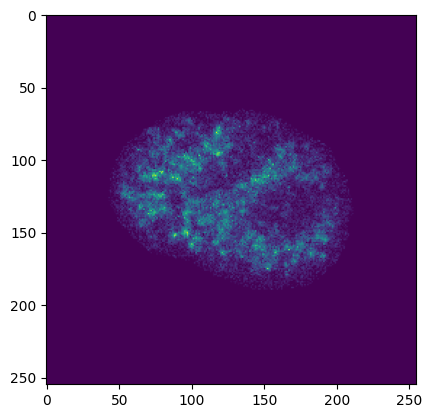

In [7]:
import matplotlib.pyplot as plt

print(ds.imgs.keys())
plt.imshow(ds.imgs["test"].get_object_img(ds.imgs["test"].obj_ids[0], channel_ids=0, img_size=255)[:, :, 0])

[NNDataset][] also contains attributes `x` and `y`, which are numpy arrays for the VAE input and output. 
`x` is either the multiplexed pixel profiles (number of pixels x neighbours x neighbours x channels) or the multiplexed pixel profiles and the condition labels.

[NNDataset]: ../classes/campa.data.NNDataset.rst

In [8]:
# get x without condition
x = ds.x("val", is_conditional=False)
print(x.shape)

# get x with condition
x, c = ds.x("train", is_conditional=True)
print(x.shape, c.shape)

(12340, 3, 3, 34)
(50310, 3, 3, 34) (50310, 14)


For neural network training, we use the [NNDataset.get_tf_dataset][] method which returns a tensorflow dataset.

[NNDataset.get_tf_dataset]: ../classes/campa.data.NNDataset.get_tf_dataset.rst

In [9]:
# dataset can returrn a tf dataset for using with e.g. keras
tf_ds = ds.get_tf_dataset(split="train", is_conditional=True)
print(tf_ds)

for x, y in tf_ds.take(1):
    # x here contains x, condition
    print(len(x), x[0].shape, x[1].shape)
    print(y.shape)

2022-10-28 14:32:57.349242: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-28 14:32:57.350309: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-28 14:32:57.350394: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cpusrv22.scidom.de): /proc/driver/nvidia/version does not exist
2022-10-28 14:32:57.383758: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<FlatMapDataset element_spec=((TensorSpec(shape=(3, 3, 34), dtype=tf.float32, name=None), TensorSpec(shape=(14,), dtype=tf.float32, name=None)), TensorSpec(shape=(34,), dtype=tf.float32, name=None))>
2 (3, 3, 34) (14,)
(34,)


For more information on the training and evaluation process, see [the tutorial on training cVAE models](train.ipynb)